# Week 11 Homework (9)


## Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it
4. Describe how to use this to create arbitrary multivariate GLM regressions

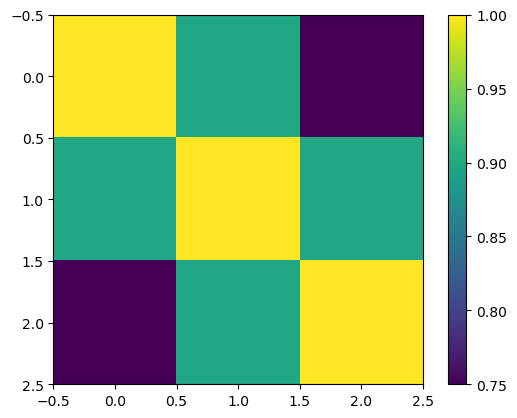

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();


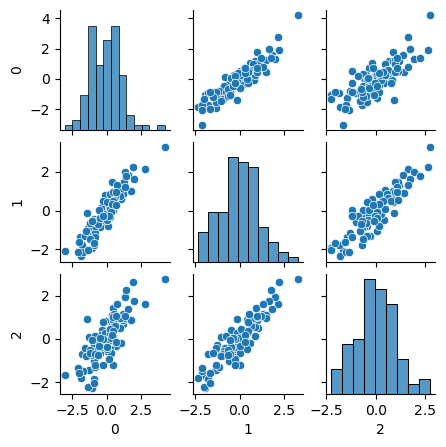

In [ ]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

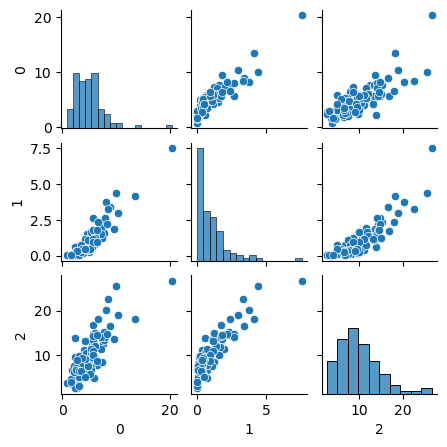

In [ ]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5);

In [ ]:
import pymc as pm
import arviz as az

with pm.Model() as copula:

    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])
    y0_ = pm.Deterministic('y0_',
            pm.Normal.icdf(
               pm.math.exp(pm.Gamma.logcdf(y0, alpha=p0, inv_beta=1)),
                           mu=0, sigma=1))

    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])
    y1_ = pm.Deterministic('y1_',
            pm.Normal.icdf(
               pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)),
                           mu=0, sigma=1))

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
    y2_ = pm.Deterministic('y2_',
            pm.Normal.icdf(
               pm.math.exp(pm.ChiSquared.logcdf(y2, nu=p2)),
                           mu=0, sigma=1))

    L,R,stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=3),
                                 compute_corr=True)

    potential = pm.Potential("MVNeval",
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R),
                             pm.math.concatenate([y0_,y1_,y2_], axis=1)))

    idata = pm.sample()

# This probally produces a lot of warnings but it will run and provide inference


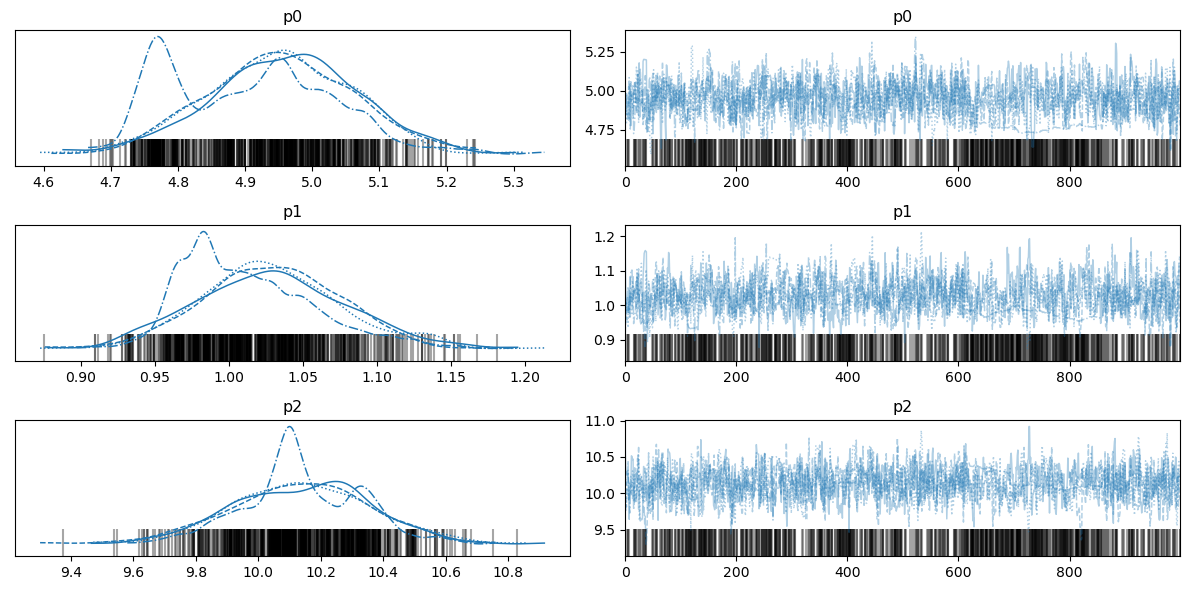

In [ ]:
# Estimation is essentially correct
az.plot_trace(idata, var_names=['p0','p1','p2'])
plt.tight_layout()

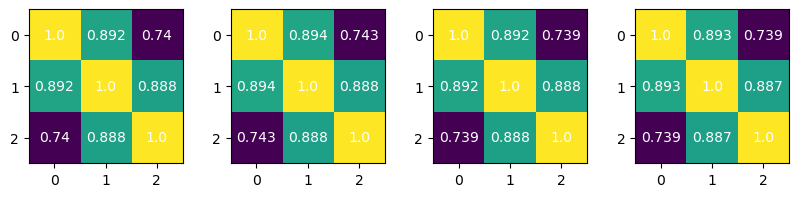

In [ ]:
# Estimation is essentially correct
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i,c in enumerate(list(idata.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)),
                       color='w', va='center', ha='center')

## Q1 Answer

### Q1.2 Answer

This is part of the provided code at the start of Q1.

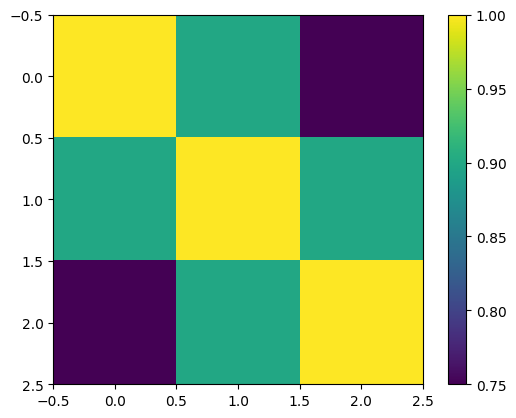

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns
import pandas as pd

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();


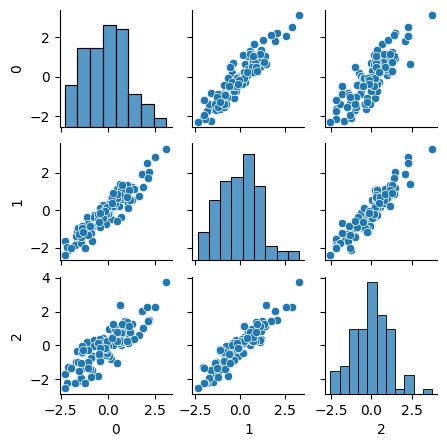

In [ ]:
sns.pairplot(pd.DataFrame(x),height=1.5);

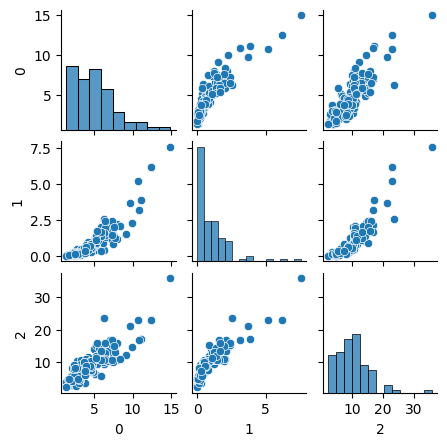

In [ ]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

sns.pairplot(pd.DataFrame(y),height=1.5);

In [ ]:
# First Pass: Marginal Parameter Estimation
with pm.Model() as marginals:
    p0 = pm.HalfNormal('p0', 10)
    pm.Gamma('y0', p0, 1, observed=y[:,0])

    p1 = pm.HalfNormal('p1', 10)
    pm.Exponential('y1', p1, observed=y[:,1])

    p2 = pm.HalfNormal('p2', 10)
    pm.ChiSquared('y2', p2, observed=y[:,2])

    marginals_trace = pm.sample()

Output()

In [ ]:
# Second Pass: Copula Estimation
# Get point estimates from first pass
p0_est = marginals_trace.posterior['p0'].mean().item()
p1_est = marginals_trace.posterior['p1'].mean().item()
p2_est = marginals_trace.posterior['p2'].mean().item()

# Transform using SciPy (equivalent to pm.Deterministic steps)
y0_unif = stats.gamma(a=p0_est, scale=1).cdf(y[:,0])
y1_unif = stats.expon(scale=1/p1_est).cdf(y[:,1])
y2_unif = stats.chi2(df=p2_est).cdf(y[:,2])

copula_data = np.column_stack([
    stats.norm.ppf(y0_unif),
    stats.norm.ppf(y1_unif),
    stats.norm.ppf(y2_unif)
])

with pm.Model() as copula_model:
    # LKJ prior for correlation matrix
    chol, corr, stds = pm.LKJCholeskyCov(
        'chol', n=3, eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=3),
        compute_corr=True
    )

    # Covariance matrix deterministic
    cov = pm.Deterministic('cov', chol.dot(chol.T))

    # Multivariate normal likelihood
    pm.MvNormal('obs', mu=np.zeros(3), chol=chol, observed=copula_data)

    # Sample from posterior
    copula_trace = pm.sample(tune=1000, cores=2)

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/tensor/subtensor.py:2585: RuntimeWarning: invalid value encountered in add
  np.add.at(x, idx, y)
/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


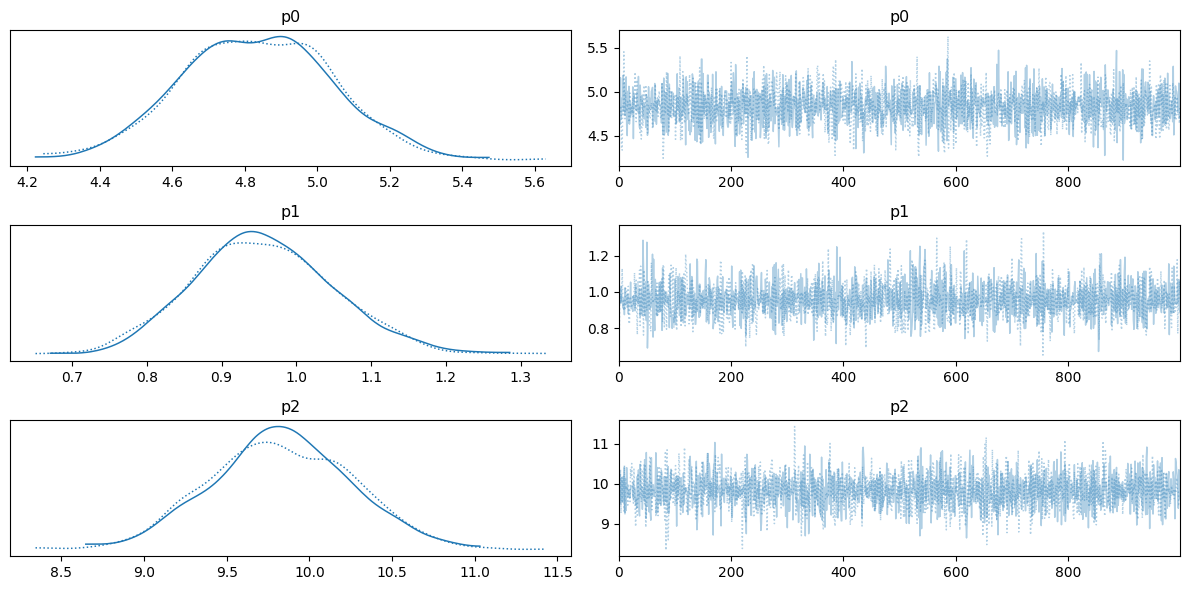

In [ ]:
az.plot_trace(marginals_trace, var_names=['p0','p1','p2'])
plt.tight_layout()

array([<Axes: title={'center': 'p0'}>, <Axes: title={'center': 'p1'}>,
       <Axes: title={'center': 'p2'}>], dtype=object)

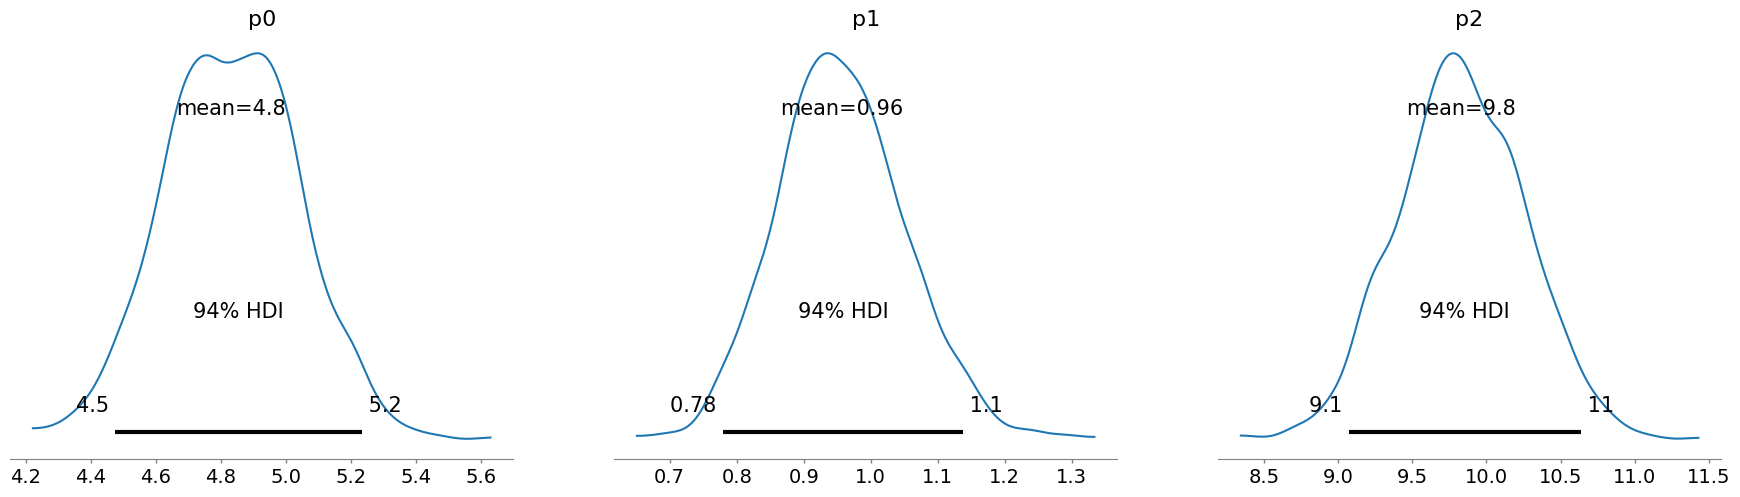

In [ ]:
az.plot_posterior(marginals_trace, var_names=['p0', 'p1', 'p2'])

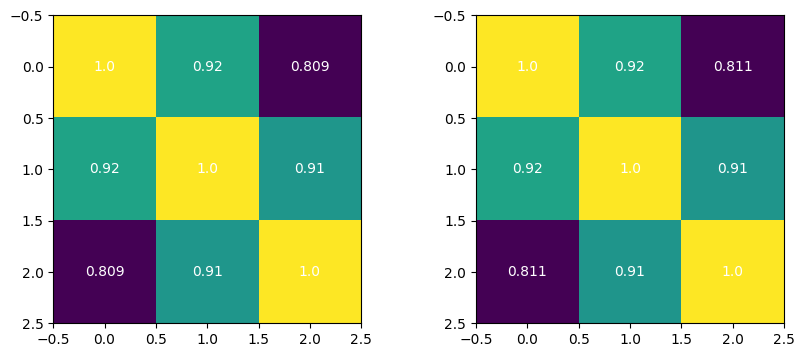

In [ ]:
# Estimated covariance matrix for each of the chains is essentially correct
fig,ax = plt.subplots(1,2,figsize=(10,4))
for i,c in enumerate(list(copula_trace.posterior['chol_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)),
                       color='w', va='center', ha='center')


### Q1.3 Answer

*Describe what a copula is and how the two verions of code implement it*

A copula is a multivariate cumulative distribution function for which the marginal probability distribution of each variable is uniform on the interval $[0, 1]$. It enables the modeling of complex dependencies between variables independent of their individual scales by separating a joint distribution of variables into their marginal distributions and dependency structure.
This is given by Sklar's theorem, which states that any multivariate joint distribution can be written in terms of its marginal distributions and a copula function that describes the dependency structure.

The one-pass approach provided simultaneously estimates both the marginal distribution parameters and the dependency structure (given by the copula parameters) in a single model, directly modeling the transformation from the original distributions to the copula space. This one-pass approach is theoretically preferable as it maintains a fully Bayesian framework that propagates uncertainty through all model components. By constructing a single integrated probability model, it preserves the formal definition of copulas as joint distributions over transformed uniform marginals, ensuring coherent uncertainty quantification where posterior distributions of marginal parameters inform the dependency structure estimation.

However, the two-pass implementation offers practical advantages in computational stability and debugging simplicity by decoupling marginal estimation from dependence modeling. Although the one-pass method is theoretically better for its complete uncertainty integration, the two-pass approach is more usable and robust in practice, particularly with complex marginal distributions or limited computational resources. The choice of which to use ultimately hinges on whether the priority is rigorous probabilistic inference (one-pass) or pragmatic implementation concerns (two-pass), with the understanding that the latter introduces controlled approximations to achieve reliable inference.

### Q1.4 Answer

*Describe how to use this to create arbitrary multivariate GLM regressions*

To create an arbitrary multivariate generalized linear model (GLM) using copulas, we extend the two approaches as follows:


**1. One-Pass Integrated Copula GLM**  
- Define separate GLM structures for each marginal.
- Use symbolic transformations (`logcdf`/`icdf`) within the model to map GLM predictions to uniform space, then to Gaussian copula space.  
- Model dependencies via an LKJCholeskyCov prior on the multivariate normal copula.  

**2. Two-Pass Decoupled Copula GLM**  
- First, fit separate GLMs to estimate marginal parameters (e.g., via maximum likelihood or Bayesian posteriors).  
- Fix these estimates, compute observation-wise CDFs, and transform them to Gaussian space.  
- Estimate copula correlations using the transformed data, ignoring uncertainty in the GLM parameters.  


## Q2: Variable Selection using Spike and Slab

Perform multivariate regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analogous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



## Q2 Answer

In [ ]:
# Generate Synthetic Data
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Configuration
np.random.seed(42)
n, p, m = 200, 10, 2  # Observations, predictors, responses

# True coefficients (sparse)
beta_true = np.zeros((m, p))
beta_true[0, [0, 3, 6]] = [1.5, -2.0, 0.8]  # Response 1
beta_true[1, [2, 5]] = [1.2, -1.5]           # Response 2

# Generate data
X = np.random.randn(n, p)
Y = X @ beta_true.T + np.random.normal(0, 0.5, size=(n, m))

In [ ]:
# Spike and Slab Model
with pm.Model() as spike_slab:
    # Inclusion probability (shared across responses)
    p_incl = pm.Beta("p_incl", alpha=1, beta=1)

    # Spike and slab components (shape = (m, p))
    spike = pm.Bernoulli("spike", p=p_incl, shape=(m, p))
    slab = pm.Normal("slab", mu=0, sigma=10, shape=(m, p))

    # Coefficient = spike * slab
    beta_ss = pm.Deterministic("beta_ss", spike * slab)

    # Likelihood - Corrected for Multivariate Output
    sigma_ss = pm.HalfNormal("sigma_ss", sigma=1, shape=m) # Response-specific sigmas
    mu_ss = pm.math.dot(X, beta_ss.T) # Linear predictor for all responses (shape: n x m)
    pm.Normal("Y_obs", mu=mu_ss, sigma=sigma_ss, observed=Y, shape=(n, m)) # Multivariate Normal likelihood


    # Sample with mixed step methods and idata_kwargs
    step1_ss = pm.Metropolis(vars=[spike])  # Discrete vars
    step2_ss = pm.NUTS(vars=[slab, sigma_ss, p_incl], target_accept=0.99)  # Continuous vars
    trace_ss = pm.sample(2000, tune=1000,
                         step=[step1_ss, step2_ss],
                         idata_kwargs={"log_likelihood": True}
                         )

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 151 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
# Diffuse normal model
with pm.Model() as diffuse:
    # Diffuse normal priors
    beta_diffuse = pm.Normal("beta_diffuse", mu=0, sigma=10, shape=(m, p))

    # Likelihood - Corrected for Multivariate Output
    sigma_diffuse = pm.HalfNormal("sigma_diffuse", sigma=1, shape=m) # Response-specific sigmas
    mu_diffuse = pm.math.dot(X, beta_diffuse.T) # Linear predictor for all responses (shape: n x m)
    pm.Normal("Y_obs", mu=mu_diffuse, sigma=sigma_diffuse, observed=Y, shape=(n, m)) # Multivariate Normal likelihood

    trace_diffuse = pm.sample(2000, tune=1000, idata_kwargs={"log_likelihood": True})

Output()

First, we look at the spike and slab posterior inclusion probabilities for each predictor in the MVR model. We want to see if the model has correctly identified the important predictors for each response variable.

In [ ]:
# Spike and slab posterior inclusion probabilities
# for each predictor in the multivariate regression model
incl_prob = trace_ss.posterior["spike"].mean(axis=(0, 1)).values
incl_prob

array([[1.00e+00, 3.25e-03, 1.55e-02, 1.00e+00, 1.00e-03, 1.00e-03,
        1.00e+00, 5.00e-03, 4.75e-03, 0.00e+00],
       [5.00e-04, 1.00e-03, 1.00e+00, 6.50e-03, 2.25e-03, 1.00e+00,
        1.00e-03, 2.50e-04, 3.75e-03, 0.00e+00]])

From the synthetic data, response variable 1 has its true relevant predictors: 1, 4, 7 (indices 0, 3, 6).

- incl_prob for Predictors 1, 4, 7 in Response 1 are all very close to 1.00, so the model correctly identified these as important.

- incl_prob for all other predictors in Response 1 are very close to 0, so the model correctly identified these as irrelevant.

From the synthetic data, response variable 2 has its true relevant predictors: 3, 6 (indices 2, 5)

- incl_prob for Predictors 3, 6 in Response 2 are both very close to 1.00, so the model correctly identified these as important.

- incl_prob for all other predictors in Response 2 are very close to 0, so the model correctly identified these as irrelevant.



Let's see the coefficient estimates and uncertainty in the posterior distributions for these models.

In [ ]:
# Spike and slab model credible intervals
az.summary(trace_ss, var_names="beta_ss")

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta_ss[0, 0]",1.467,0.040,1.393,1.541,0.001,0.001,3078.0,2543.0,1.00
"beta_ss[0, 1]",0.000,0.002,0.000,-0.000,0.000,0.001,562.0,539.0,1.00
"beta_ss[0, 2]",0.001,0.007,0.000,0.000,0.001,0.003,84.0,79.0,1.02
"beta_ss[0, 3]",-1.945,0.036,-2.016,-1.881,0.001,0.001,1321.0,242.0,1.01
"beta_ss[0, 4]",-0.000,0.000,-0.000,-0.000,0.000,0.000,1002.0,4000.0,1.00
"beta_ss[0, 5]",0.000,0.001,0.000,-0.000,0.000,0.000,2678.0,4011.0,1.00
"beta_ss[0, 6]",0.849,0.035,0.783,0.914,0.000,0.001,4971.0,2535.0,1.00
"beta_ss[0, 7]",-0.000,0.001,-0.000,-0.000,0.000,0.001,304.0,1002.0,1.01
"beta_ss[0, 8]",-0.000,0.004,-0.000,-0.000,0.000,0.002,507.0,4000.0,1.00
"beta_ss[0, 9]",0.000,0.000,0.000,0.000,0.000,NaN,4000.0,4000.0,NaN


In [ ]:
# Diffuse model credible intervals
diffuse_ci = az.summary(trace_diffuse, var_names="beta_diffuse")
diffuse_ci

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta_diffuse[0, 0]",1.455,0.042,1.379,1.534,0.0,0.001,8104.0,2201.0,1.0
"beta_diffuse[0, 1]",0.051,0.034,-0.013,0.115,0.0,0.001,7964.0,3290.0,1.0
"beta_diffuse[0, 2]",0.072,0.037,0.004,0.143,0.0,0.001,8709.0,3497.0,1.0
"beta_diffuse[0, 3]",-1.939,0.036,-2.005,-1.870,0.0,0.001,8424.0,2971.0,1.0
"beta_diffuse[0, 4]",-0.048,0.038,-0.118,0.021,0.0,0.001,8581.0,2565.0,1.0
"beta_diffuse[0, 5]",0.037,0.035,-0.030,0.099,0.0,0.001,8457.0,2418.0,1.0
"beta_diffuse[0, 6]",0.859,0.035,0.792,0.923,0.0,0.001,8717.0,2451.0,1.0
"beta_diffuse[0, 7]",0.026,0.039,-0.045,0.102,0.0,0.001,8339.0,2880.0,1.0
"beta_diffuse[0, 8]",-0.051,0.039,-0.123,0.023,0.0,0.001,9299.0,3371.0,1.0
"beta_diffuse[0, 9]",-0.000,0.037,-0.068,0.069,0.0,0.001,8556.0,3112.0,1.0


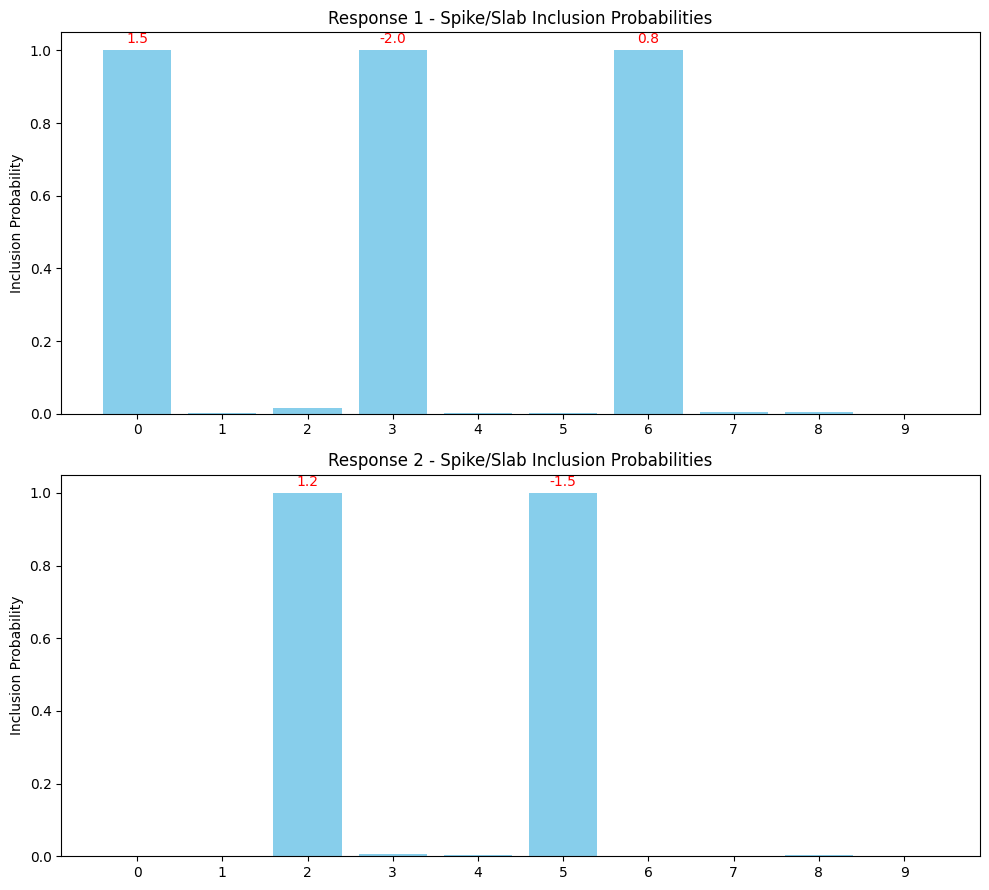

In [ ]:
# Plotting results
fig, axes = plt.subplots(2, 1, figsize=(10, 9))
ax_incl_prob = axes[0:2] # Inclusion probability plots on the first two axes

for k in range(m):
    # Plot spike and slab inclusion probabilities
    ax_incl_prob[k].bar(range(p), incl_prob[k], color='skyblue', label='Inclusion Prob')
    ax_incl_prob[k].set_xticks(range(p))
    ax_incl_prob[k].set_title(f"Response {k+1} - Spike/Slab Inclusion Probabilities")
    ax_incl_prob[k].set_ylabel("Inclusion Probability")

    # Overlay true coefficients
    true_coefs = beta_true[k]
    for j in range(p):
        if true_coefs[j] != 0:
            ax_incl_prob[k].text(j, incl_prob[k][j] + 0.02, f"{true_coefs[j]:.1f}", # Adjusted text position
                        ha='center', color='red')
plt.tight_layout()
plt.show()

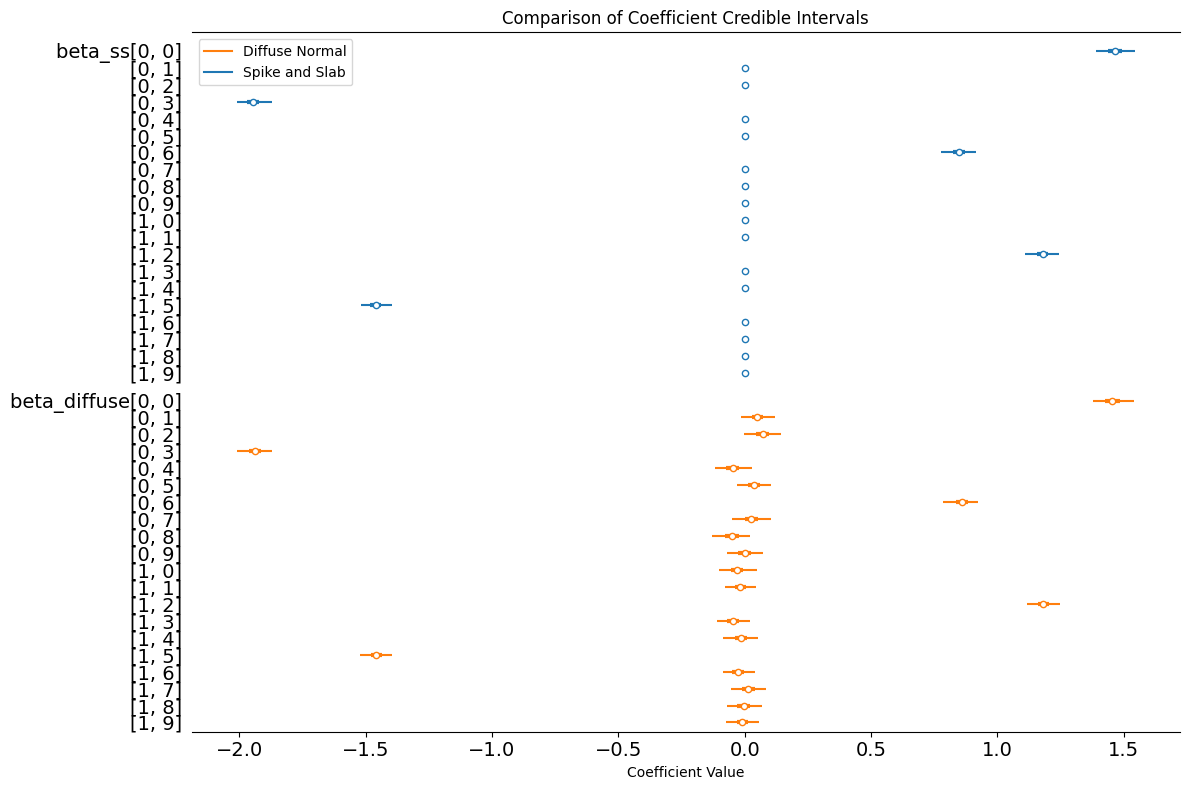

In [ ]:
# Visual comparison of the credible intervals
fig_forest_compare, ax_forest_compare = plt.subplots(figsize=(12, 8))

az.plot_forest(
    [trace_ss, trace_diffuse],  # Pass a list of InferenceData objects
    var_names=["beta_ss", "beta_diffuse"],  # List of variable names for each model
    model_names=["Spike and Slab", "Diffuse Normal"],  # List of model names for labels
    combined=True,
    hdi_prob=0.95,
    ax=ax_forest_compare  # Pass the axes object
)

ax_forest_compare.set_title("Comparison of Coefficient Credible Intervals")
ax_forest_compare.set_xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

Here is a WAIC comparison

In [ ]:
# Calculate WAIC for model comparison
waic_ss = az.waic(trace_ss, var_name="Y_obs")
waic_diffuse = az.waic(trace_diffuse, var_name="Y_obs")

print("\nWAIC Comparison:")
print(f"Spike and Slab WAIC: {waic_ss.elpd_waic:.2f}")
print(f"Diffuse Normal WAIC: {waic_diffuse.elpd_waic:.2f}")
print(f"WAIC Difference (SS - Diffuse): {waic_ss.elpd_waic - waic_diffuse.elpd_waic:.2f}") # Added WAIC difference


WAIC Comparison:
Spike and Slab WAIC: -281.15
Diffuse Normal WAIC: -289.29
WAIC Difference (SS - Diffuse): 8.14


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Since this difference is positive, it suggests the Spike and Slab model might be too restrictive, or that the priors are not well-aligned with the data in some way. I would expect the Spike and Slab model to be performing better here; it might be due to the high number of divergences in the NUTS sampler, but I am not entirely sure why that is the case because the target_accept parameter is already much higher than the default.

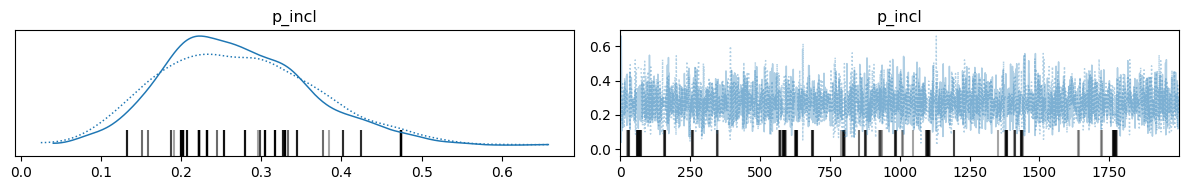

In [ ]:
az.plot_trace(trace_ss, var_names=['p_incl'])

plt.tight_layout()

In a situation where one might believe the true relationship is sparse, you would generally expect the Spike and Slab model to do better because it is designed to handle sparsity. If it performs well, it should correctly identify the relevant variables (high inclusion probabilities for true predictors, low for irrelevant ones) and provide reasonably accurate estimates for the important coefficients. It should ideally also achieve better out-of-sample predictive performance (lower WAIC) due to reduced overfitting.

## Q3 Variable Selection

Perform multivariate regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analogous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



## Q3 Answer

In [ ]:
# Q3 Answer

# Re-use data generation from Q2
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Configuration
np.random.seed(42)
n, p, m = 200, 10, 2  # Observations, predictors, responses

# True coefficients (sparse)
beta_true = np.zeros((m, p))
beta_true[0, [0, 3, 6]] = [1.5, -2.0, 0.8]  # Response 1
beta_true[1, [2, 5]] = [1.2, -1.5]           # Response 2

# Generate data
X = np.random.randn(n, p)
Y = X @ beta_true.T + np.random.normal(0, 0.5, size=(n, m))


In [ ]:
# Horseshoe Model
with pm.Model() as horseshoe_model:
    # Global shrinkage parameter
    tau0 = 0.1 # Fixed prior for global shrinkage
    tau = pm.HalfCauchy("tau", beta=tau0)

    # Local shrinkage parameters
    lambdas = pm.HalfCauchy("lambdas", beta=1, shape=(m, p))

    # Prior for coefficients with horseshoe shrinkage
    beta_hs_ = pm.Normal("beta_hs_", mu=0, sigma=1, shape=(m, p)) # Base normal prior
    beta_hs = pm.Deterministic("beta_hs", beta_hs_ * tau * lambdas) # Horseshoe coefficients

    # Likelihood - Corrected for Multivariate Output
    sigma_hs = pm.HalfNormal("sigma_hs", sigma=1, shape=m) # Response-specific sigmas
    mu_hs = pm.math.dot(X, beta_hs.T) # Linear predictor
    pm.Normal("Y_obs", mu=mu_hs, sigma=sigma_hs, observed=Y, shape=(n, m)) # Multivariate Normal likelihood

    trace_hs = pm.sample(2000, tune=1000, idata_kwargs={"log_likelihood": True})


Output()

ERROR:pymc.stats.convergence:There were 315 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
# Spike and Slab Model (re-using from Q2 for comparison)
with pm.Model() as spike_slab_model:
    # Inclusion probability (shared across responses)
    p_incl = pm.Beta("p_incl", alpha=1, beta=1)

    # Spike and slab components (shape = (m, p))
    spike = pm.Bernoulli("spike", p=p_incl, shape=(m, p))
    slab = pm.Normal("slab", mu=0, sigma=10, shape=(m, p))

    # Coefficient = spike * slab
    beta_ss = pm.Deterministic("beta_ss", spike * slab)

    # Likelihood - Corrected for Multivariate Output
    sigma_ss = pm.HalfNormal("sigma_ss", sigma=1, shape=m) # Response-specific sigmas
    mu_ss = pm.math.dot(X, beta_ss.T) # Linear predictor
    pm.Normal("Y_obs", mu=mu_ss, sigma=sigma_ss, observed=Y, shape=(n, m)) # Multivariate Normal likelihood

    # Sample with mixed step methods and idata_kwargs
    step1_ss = pm.Metropolis(vars=[spike])  # Discrete vars
    step2_ss = pm.NUTS(vars=[slab, sigma_ss, p_incl], target_accept=0.99)  # Continuous vars
    trace_ss_comp = pm.sample(2000, tune=1000,
                         step=[step1_ss, step2_ss],
                         idata_kwargs={"log_likelihood": True}
                         )

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 132 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
# Analyze Horseshoe Model Results
print("Horseshoe Model Summary:")
az.summary(trace_hs, var_names="beta_hs")

Horseshoe Model Summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta_hs[0, 0]",1.458,0.041,1.385,1.537,0.001,0.001,3423.0,2906.0,1.0
"beta_hs[0, 1]",0.025,0.029,-0.018,0.084,0.001,0.000,1699.0,3132.0,1.0
"beta_hs[0, 2]",0.043,0.036,-0.015,0.110,0.001,0.001,1906.0,2521.0,1.0
"beta_hs[0, 3]",-1.940,0.036,-2.007,-1.873,0.001,0.000,3257.0,3176.0,1.0
"beta_hs[0, 4]",-0.022,0.029,-0.082,0.024,0.001,0.000,2238.0,3580.0,1.0
"beta_hs[0, 5]",0.017,0.028,-0.027,0.080,0.001,0.001,2572.0,2422.0,1.0
"beta_hs[0, 6]",0.851,0.035,0.786,0.916,0.001,0.001,3647.0,3045.0,1.0
"beta_hs[0, 7]",0.010,0.027,-0.039,0.066,0.000,0.001,2881.0,2094.0,1.0
"beta_hs[0, 8]",-0.025,0.033,-0.092,0.027,0.001,0.000,2059.0,3178.0,1.0
"beta_hs[0, 9]",-0.001,0.023,-0.049,0.047,0.000,0.000,3981.0,3355.0,1.0


In [ ]:
# Analyze Spike and Slab Model Results (for comparison)
print("Spike and Slab Model Summary:")
az.summary(trace_ss_comp, var_names="beta_ss")

Spike and Slab Model Summary:


/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta_ss[0, 0]",1.469,0.042,1.393,1.551,0.001,0.001,3023.0,1542.0,1.00
"beta_ss[0, 1]",0.000,0.007,0.000,0.000,0.000,0.003,467.0,487.0,1.01
"beta_ss[0, 2]",0.000,0.005,-0.000,0.000,0.000,0.002,327.0,309.0,1.01
"beta_ss[0, 3]",-1.945,0.035,-2.017,-1.883,0.001,0.001,3002.0,2364.0,1.00
"beta_ss[0, 4]",-0.000,0.003,0.000,-0.000,0.000,0.001,1774.0,4000.0,1.00
"beta_ss[0, 5]",0.000,0.000,-0.000,0.000,0.000,NaN,4000.0,4000.0,NaN
"beta_ss[0, 6]",0.848,0.036,0.781,0.912,0.001,0.001,3323.0,1903.0,1.00
"beta_ss[0, 7]",0.000,0.001,0.000,-0.000,0.000,0.000,11457.0,4011.0,1.00
"beta_ss[0, 8]",-0.000,0.003,0.000,0.000,0.000,0.001,605.0,1336.0,1.00
"beta_ss[0, 9]",-0.000,0.001,0.000,0.000,0.000,0.000,2002.0,4000.0,1.00


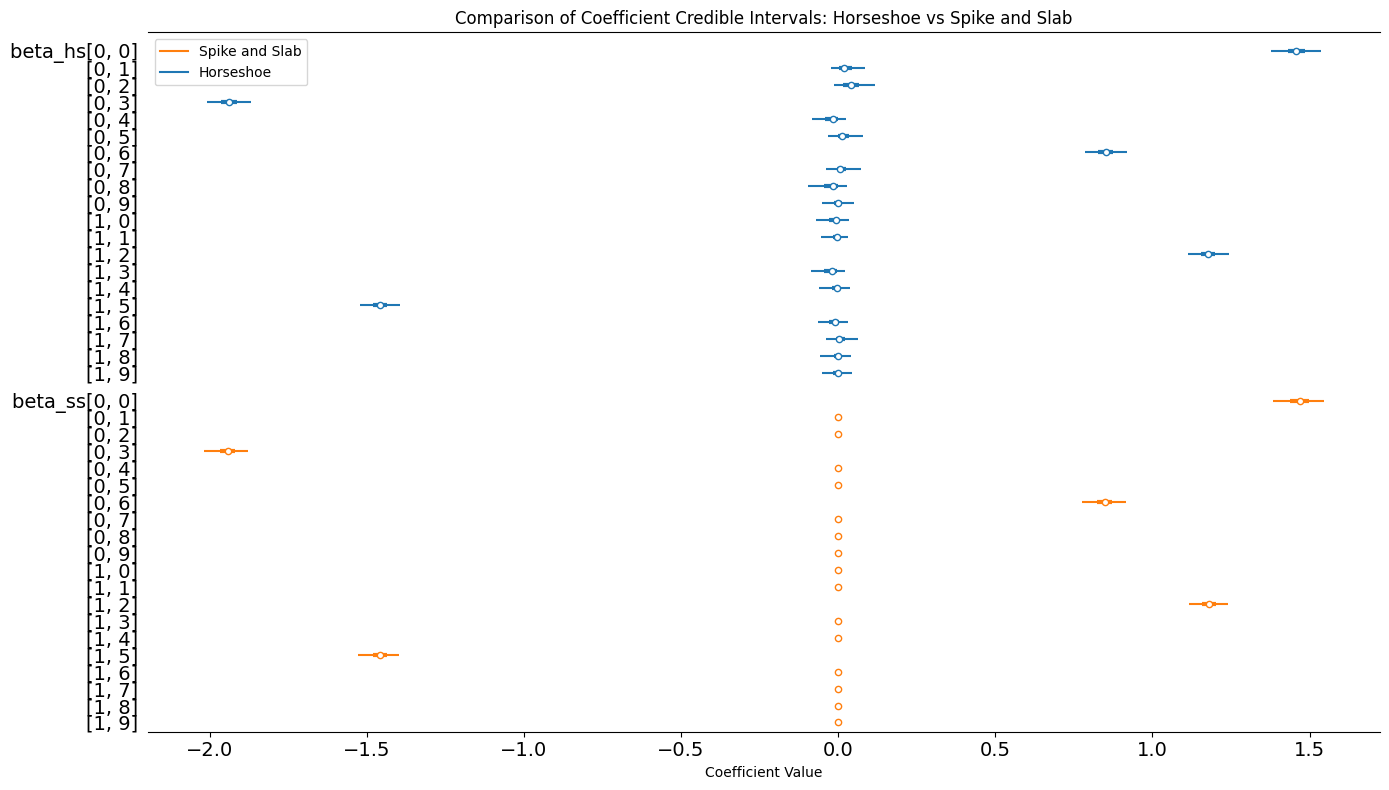

In [ ]:
# Visual Comparison of Credible Intervals - Horseshoe vs Spike & Slab
fig_forest_compare_hs_ss, ax_forest_compare_hs_ss = plt.subplots(figsize=(14, 8))

az.plot_forest(
    [trace_hs, trace_ss_comp],  # List of InferenceData objects
    var_names=["beta_hs", "beta_ss"],  # List of variable names for each model
    model_names=["Horseshoe", "Spike and Slab"],  # Model names for labels
    combined=True,
    hdi_prob=0.95,
    ax=ax_forest_compare_hs_ss  # Axes object
)

ax_forest_compare_hs_ss.set_title("Comparison of Coefficient Credible Intervals: Horseshoe vs Spike and Slab")
ax_forest_compare_hs_ss.set_xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

In [ ]:
# WAIC Comparison - Horseshoe vs Spike & Slab
waic_hs = az.waic(trace_hs, var_name="Y_obs")
waic_ss_comp = az.waic(trace_ss_comp, var_name="Y_obs")

print("\nWAIC Comparison: Horseshoe vs Spike and Slab")
print(f"Horseshoe WAIC: {waic_hs.elpd_waic:.2f}")
print(f"Spike and Slab WAIC: {waic_ss_comp.elpd_waic:.2f}")
print(f"WAIC Difference (HS - SS): {waic_hs.elpd_waic - waic_ss_comp.elpd_waic:.2f}")


WAIC Comparison: Horseshoe vs Spike and Slab
Horseshoe WAIC: -284.43
Spike and Slab WAIC: -281.25
WAIC Difference (HS - SS): -3.18


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


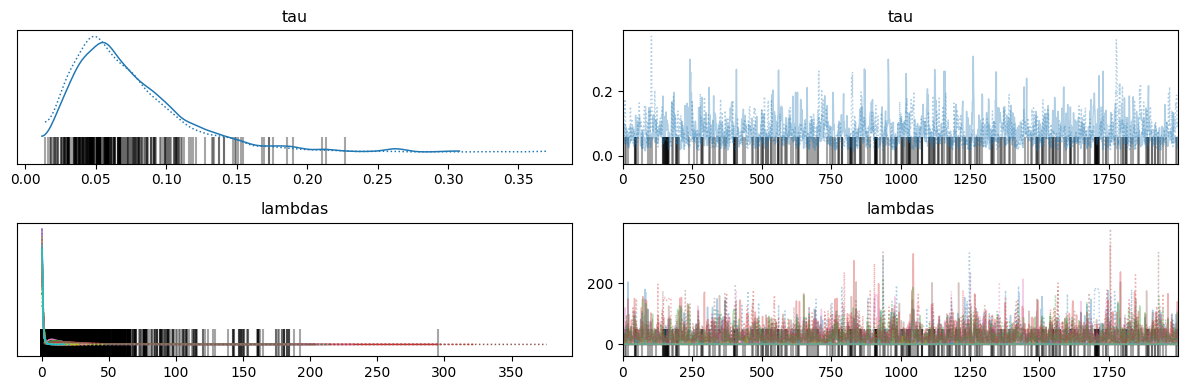

In [ ]:
az.plot_trace(trace_hs, var_names=['tau', 'lambdas'])
plt.tight_layout()
plt.show()

### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



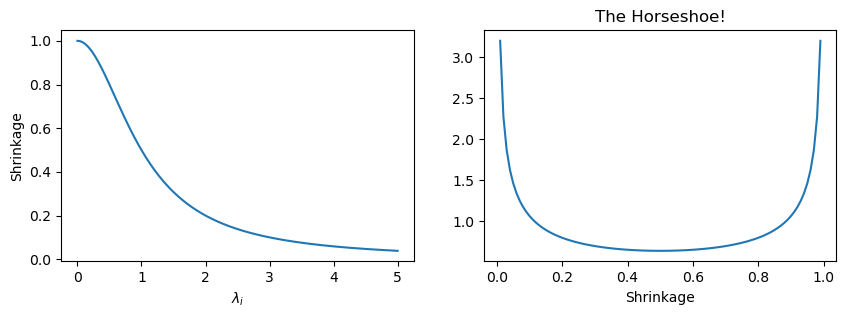

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$")
# change of variables:
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage,
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) *
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");